In [1]:
import numpy as np
import os

In [2]:
def get_files(just_max_peaks_diretory: str, attempts: int, files_amount: int) -> "list[list[np.ndarray]]":
    """
    Loads multiple .npy files from a specified directory structure.

    Args:
        just_max_peaks_diretory (str): The base directory containing subdirectories for each attempt.
        attempts (int): The number of attempts or subdirectories to process.
        files_amount (int): The number of .npy files to load from each subdirectory.

    Returns:
        list[list[np.ndarray]]: A nested list where each sublist contains the loaded .npy files for a specific attempt.
    """
    tries = []
    for i in range(attempts):
        energylist = []
        directorypath = f'{just_max_peaks_diretory}/{i+1}'
        for j in range(files_amount):
            energylist.append(np.load(directorypath +'/microphone' + str(j+1) + '.npy'))
        tries.append(energylist)
    return tries

tries_lin = get_files(just_max_peaks_diretory='../outputs/just_max_peaks/tries_lin', attempts=10, files_amount=9)
tries_co = get_files(just_max_peaks_diretory='../outputs/just_max_peaks/tries_co', attempts=10, files_amount=9)

In [3]:
def get_mel_spectrograms(directory: str) -> "list[np.ndarray]":
    """
    Loads multiple .npy files from a specified directory.

    Args:
        directory (str): The directory containing the .npy files to load.

    Returns:
        list[np.ndarray]: A list containing the loaded .npy files.
    """
    files = os.listdir(directory)
    data = []
    for file in files:
        if file.endswith('.npy'):
            filepath = os.path.join(directory, file)
            mel_spectrogram = np.load(filepath)
            data.append(mel_spectrogram)
    return data

lin_directory = '../data/aligned/lin'
co_directory = '../data/aligned/co'

lin_mel_spectrograms = get_mel_spectrograms(directory=lin_directory)
co_mel_spectrograms = get_mel_spectrograms(directory=co_directory)

In [4]:
def get_frequency_bands(
    mel_spectrograms_data: "list[np.ndarray]",
    attempts: int,
    files_amount: int,
    tries: "list[list[np.ndarray]]",
    is_lin: bool,
) -> "list[list[np.ndarray]]":
   
    """
    Calculate frequency bands from mel spectrogram data.
    Args:
        mel_spectrograms_data (list[np.ndarray]): List of mel spectrogram arrays.
        attempts (int): Number of attempts to process.
        files_amount (int): Number of files to process.
        tries (list[list[np.ndarray]]): List of lists containing arrays of attempts.
        is_lin (bool): Flag to determine if the frequency should be linear.
    Returns:
        list[list[np.ndarray]]: List of lists containing frequency bands for each attempt and file.
    """

    tries_frequency_bands = []
    for j in range(attempts):
        frequency_bands = []

        for i in range(files_amount):
            array = np.zeros(tries[j][i].shape[0])
            frequency_bands.append(array)

            for k in range(tries[j][i].shape[0]):
                if tries[j][i][k] > 0.0001:
                    if is_lin:
                        frequency_bands[i][k] = (
                            np.argmax(mel_spectrograms_data[i][:, k]) + 60
                        )
                    else:
                        frequency_bands[i][k] = np.argmax(
                            mel_spectrograms_data[i][:, k]
                        )

        tries_frequency_bands.append(frequency_bands)

    return tries_frequency_bands


tries_lin_frequency_bands = get_frequency_bands(
    mel_spectrograms_data=lin_mel_spectrograms,
    attempts=10,
    files_amount=9,
    tries=tries_lin,
    is_lin=True,
)
tries_co_frequency_bands = get_frequency_bands(
    mel_spectrograms_data=co_mel_spectrograms,
    attempts=10,
    files_amount=9,
    tries=tries_co,
    is_lin=False,
)

In [5]:
def save_data(
    data_destination_path: str,
    attempts: int,
    files_amount: int,
    tries_frequency_bands: "list[list[np.ndarray]]",
) -> None:
    """
    Save data to a specified directory structure.

    Args:
        data_destination_path (str): The base directory to save the data.
        attempts (int): The number of attempts or subdirectories to process.
        files_amount (int): The number of .npy files to save in each subdirectory.
    """
    for i in range(attempts):
        data_directory_path = f"{data_destination_path}/{i+1}"
        if not os.path.exists(data_directory_path):
            os.makedirs(data_directory_path)
        for j in range(files_amount):
            np.save(
                data_directory_path + f"/microphone{j+1}.npy",
                tries_frequency_bands[i][j],
            )


save_data(
    data_destination_path="../outputs/frequency/tries_lin",
    attempts=10,
    files_amount=9,
    tries_frequency_bands=tries_lin_frequency_bands,
)
save_data(
    data_destination_path="../outputs/frequency/tries_co",
    attempts=10,
    files_amount=9,
    tries_frequency_bands=tries_co_frequency_bands,
)

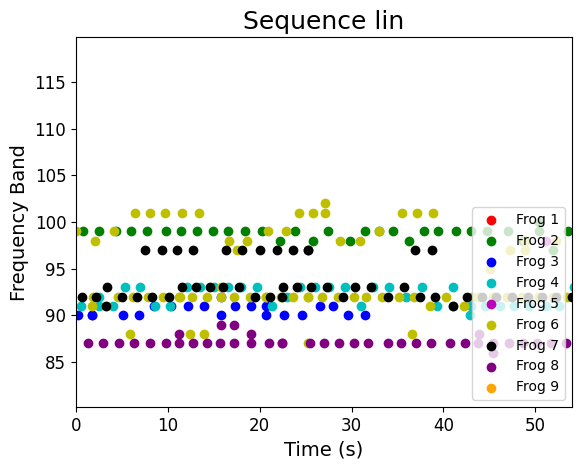

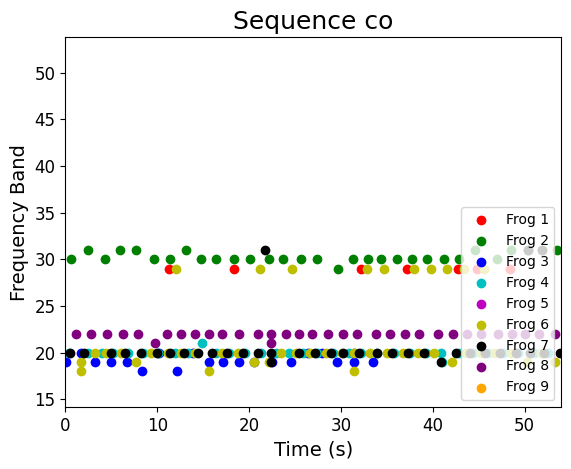

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_frequency_graph(
    tries_frequency_bands: "list[list[np.ndarray]]",
    graph_title: str,
    hop_length: int = 512,
    sample_rate: int = 96000,
    xlim_left: int = 0,
    xlim_right: int = 54,
) -> None:
    """
    Plots a frequency graph based on the provided frequency bands.

    Parameters:
    - tries_frequency_bands (list[list[np.ndarray]]): A list of lists containing numpy arrays with frequency band data.
    - hop_length (int, optional): The hop length used in the analysis. Default is 512.
    - sample_rate (int, optional): The sample rate of the audio data. Default is 96000.
    - xlim_left (int, optional): The left limit for the x-axis. Default is 0.
    - xlim_right (int, optional): The right limit for the x-axis. Default is 54.

    Returns:
    - None: This function does not return any value. It displays a plot.
    """

    time_interval = hop_length / sample_rate
    colors = ["r", "g", "b", "c", "m", "y", "k", "purple", "orange"]

    for i, array in enumerate(tries_frequency_bands[0]):
        non_zero_inexes = np.where(array > 0.0001)[0]
        non_zero_values = array[non_zero_inexes]

        miliseconds = non_zero_inexes * time_interval

        plt.scatter(miliseconds, non_zero_values, color=colors[i], label=f"Frog {i+1}")

    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Frequency Band", fontsize=14)
    plt.legend(loc="lower right")
    plt.title(graph_title, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=12)  
    plt.xlim(xlim_left, xlim_right)

    plt.show()


plot_frequency_graph(
    tries_frequency_bands=tries_lin_frequency_bands, graph_title="Sequence lin"
)
plot_frequency_graph(
    tries_frequency_bands=tries_co_frequency_bands, graph_title="Sequence co"
)

In [ ]:
def get_frequency_graph_pipeline(
    just_max_peaks_diretory_lin: str,
    just_max_peaks_diretory_co: str,
    attempts: int,
    files_amount: int,
    lin_mel_spectrograms_directory: str,
    co_mel_spectrograms_directory: str,
    data_destination_path_lin: str,
    data_destination_path_co: str,
    verbose: bool = False,
    plots: bool = True
) -> None:

    if verbose:
        print("------------------GETTING LIN MAX PEAKS FILES INFO---------------")
    tries_lin = get_files(
        just_max_peaks_diretory=just_max_peaks_diretory_lin,
        attempts=attempts,
        files_amount=files_amount,
    )
    if verbose:
        print("------------------GETTING CO MAX PEAKS FILES INFO---------------")
    tries_co = get_files(
        just_max_peaks_diretory=just_max_peaks_diretory_co,
        attempts=attempts,
        files_amount=files_amount,
    )

    if verbose:
        print("------------------GETTING LIN MEL SPECTROGRAMS INFO---------------")
    lin_mel_spectrograms = get_mel_spectrograms(directory=lin_mel_spectrograms_directory)
    if verbose:
        print("------------------GETTING CO MEL SPECTROGRAMS INFO---------------")
    co_mel_spectrograms = get_mel_spectrograms(directory=co_mel_spectrograms_directory)

    if verbose:
        print("------------------GETTING LIN FREQUENCY BANDS INFO---------------")
    tries_lin_frequency_bands = get_frequency_bands(
    mel_spectrograms_data=lin_mel_spectrograms,
    attempts=attempts,
    files_amount=files_amount,
    tries=tries_lin,
    is_lin=True,
    )
    if verbose:
        print("------------------GETTING CO FREQUENCY BANDS INFO---------------")
    tries_co_frequency_bands = get_frequency_bands(
        mel_spectrograms_data=co_mel_spectrograms,
        attempts=attempts,
        files_amount=files_amount,
        tries=tries_co,
        is_lin=False,
    )

    if verbose:
        print("------------------SAVING LIN DATA---------------")
    save_data(
        data_destination_path=data_destination_path_lin,
        attempts=attempts,
        files_amount=files_amount,
        tries_frequency_bands=tries_lin_frequency_bands,
    )
    if verbose:
        print("------------------SAVING CO DATA---------------")
    save_data(
        data_destination_path=data_destination_path_co,
        attempts=attempts,
        files_amount=files_amount,
        tries_frequency_bands=tries_co_frequency_bands,
    )
    if plots:
        if verbose:
            print("------------------PLOTTING LIN GRAPH---------------")
        plot_frequency_graph(
            tries_frequency_bands=tries_lin_frequency_bands, graph_title="Sequence lin"
        )
        if verbose:
            print("------------------PLOTTING CO GRAPH---------------")
        plot_frequency_graph(
            tries_frequency_bands=tries_co_frequency_bands, graph_title="Sequence co"
        )

In [ ]:
attempts = 10
files_amount = 9
just_max_peaks_diretory_lin = '../outputs/just_max_peaks/tries_lin'
just_max_peaks_diretory_co = '../outputs/just_max_peaks/tries_co'

lin_directory = '../data/aligned/lin'
co_directory = '../data/aligned/co'

data_destination_path_lin = "../outputs/frequency/tries_lin"
data_destination_path_co = "../outputs/frequency/tries_co"


get_frequency_graph_pipeline(
    just_max_peaks_diretory_lin=just_max_peaks_diretory_lin,
    just_max_peaks_diretory_co=just_max_peaks_diretory_co,
    attempts=attempts,
    files_amount=files_amount,
    lin_mel_spectrograms_directory=lin_directory,
    co_mel_spectrograms_directory=co_directory,
    data_destination_path_lin=data_destination_path_lin,
    data_destination_path_co=data_destination_path_co,
    verbose=True,
    plots=True
)